<center> <h1> Target2 compound filtering into an unbiased dataset relative to source, microscope configuration and well and which are phenotypically active </h1> </center>

Our precedent approach lead to a dataset which was unbias in term of metadata but our classifier was not performing so well. Since we cannot have a great StarGAN if we don't have a great classifier. Therefore, the goal is to find a more meaningful approach to downsample the target 2 dataset. The way we can do it is by using mAP to retrieve only replicate which are phenotypically active and consistent within their moa. By doing so, we can afterward rebalancing the dataset. This framework should help having a dataset unbiased in term of metadata and phenotypically relevant enough to make sure that our later on classifier will be good enough.  

# 1) Merging table together

In [246]:
import polars as pl
import pandas as pd
from data_v2 import get_table
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn.preprocessing import RobustScaler
import umap 
import get_features as gf
import plot_distribution_table as pdt
from features_engineering import features_drop_corr_gpu
from copairs.map import average_precision, mean_average_precision
from copairs.compute import p_values

import logging
import warnings
logging.basicConfig(format="%(levelname)s:%(asctime)s:%(name)s:%(message)s")
logging.getLogger("copairs").setLevel(logging.INFO)

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
compound = get_table("compound")
well = get_table("well")
plate = get_table("plate")
micro = get_table("microscope_config")
target2 = get_table("target2")
target2_plate = get_table("target2_plate")

In [3]:
# Removal of source_9 and source_1 because the plate is not similar
well = well.filter(pl.col("Metadata_Source").str.contains("_9|_1$") != True)

plate = plate.select(pl.all().exclude("Metadata_Source"))

micro_features = ['Metadata_Source','Metadata_Microscope_Name',
                  'Metadata_Widefield_vs_Confocal',
                  'Metadata_Excitation_Type',
                  'Metadata_Objective_NA',
                  'Metadata_Filter_Configuration']

#rename source so it is consistent with the other data
micro = micro.with_columns(
    ("source_" + pl.col("Metadata_Source").cast(str)).alias("Metadata_Source")).select(
    pl.col(micro_features))

#create a unique ID identifier per microscope configuration
micro = micro.filter(pl.col("Metadata_Source").str.contains("_[19]$|_15$") != True)
map_micro_ID = micro.select(pl.col("Metadata_Source"),
                            pl.struct(pl.all().exclude("Metadata_Source")).alias("unique"))\
                            .sort(by="unique")\
                            .select(pl.col("Metadata_Source"), pl.col("unique").rle_id().alias("Micro_id"))

micro = micro.join(map_micro_ID,
           on="Metadata_Source",
           how="left")

In [4]:
# check if InChIKey is a unique identifier
target2.group_by("InChIKey").agg(pl.all().n_unique()).with_columns(
    pl.sum_horizontal(pl.all().exclude("InChIKey"))).filter(pl.col("sum")>8)

InChIKey,broad_sample,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI,sum
str,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""LOUPRKONTZGTKE…",2,2,2,2,1,1,1,1,12
"""UTBOEBCWXGDOGI…",2,1,2,1,1,1,1,1,10
"""AJVXVYTVAAWZAP…",2,1,2,1,1,1,1,1,10
"""QIHBWVVVRYYYRO…",2,1,2,1,1,1,1,1,10
"""GJFCONYVAUNLKB…",2,1,2,1,1,1,1,1,10


Here we can notice that InChIKey is not a unique identifier. We should remove duplicates to avoid complication later on.

broad_sample, pubchem_cid can be removed without hesitation (not useful next for mergin etc.) pert_iname and target (target can give insight on moa or it can be another way to group sample than moa. and pert_iname is how we're going to merge moa and our table at the end) can still be informative so we should deal with this sample: "LOUPRKONTZGTKE..."

In [5]:
target2.filter(pl.col("InChIKey").str.contains("LOUPRKONTZGTKE"))

broad_sample,InChIKey,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI
str,str,str,i64,str,str,str,str,str
"""BRD-K48278478-…","""LOUPRKONTZGTKE…","""quinine""",94175,"""KCNN4""","""trt""","""NA""","""C=CC1CN2CCC1CC…","""InChI=1S/C20H2…"
"""BRD-K59632282-…","""LOUPRKONTZGTKE…","""quinidine""",441074,"""KCNK1""","""trt""","""NA""","""C=CC1CN2CCC1CC…","""InChI=1S/C20H2…"


When looking at the following website, the InChiKey is supposed to be different: 
* quinidine:
  - [LOUPRKONTZGTKE-WGFDLZGGSA-N](https://webbook.nist.gov/cgi/inchi?ID=C56542) (from webbook chemistry NIST)
  - [LOUPRKONTZGTKE-LHHVKLHASA-N](https://pubchem.ncbi.nlm.nih.gov/compound/Quinidine#section=Crystal-Structures) (from PubChem NIH)
* quinine:
  - [LOUPRKONTZGTKE-UHFFFAOYSA-N](https://webbook.nist.gov/cgi/inchi/InChI%3D1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10-19(22)20(23)16-6-8-21-18-5-4-15(24-2)11-17(16)18/h3-6%2C8%2C11%2C13-14%2C19-20%2C23H%2C1%2C7%2C9-10%2C12H2%2C2H3) (from webbook chemistry NIST)
  - [LOUPRKONTZGTKE-WZBLMQSHSA-N](https://pubchem.ncbi.nlm.nih.gov/compound/Quinine#section=Computed-Descriptors) (from PubChem NIH)

The difference happens to be within the 8 digits which account for the stereochemistry cf [original_paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0068-4/figures/7), for instance: "LHHVKLHA".

Let's see the one chosen in Target2 and the amount of different digits in compound. 

In [6]:
target2.filter(pl.col("InChIKey").str.contains("LOUPRKONTZGTKE")).select(
    pl.col("InChIKey").unique()).to_numpy()

array([['LOUPRKONTZGTKE-UHFFFAOYSA-N']], dtype=object)

In [7]:
# We want to see how does that compare to the original table compound
compound.select(pl.col("Metadata_InChIKey").str.extract("\w+-(\w{8}SA)-").unique())

Metadata_InChIKey
str
null
"""QOPSANPBSA"""
"""UHFFFAOYSA"""


In [8]:
# exclude quinidine
target2 = target2.filter(pl.col("broad_sample").str.contains("BRD-K59632282-") != True)
# remove broad_sample and pubchem_id which are no use
target2 = target2.select(pl.all().exclude(["broad_sample", "pubchem_cid"])).unique()

# finally merge tables together
merge_table = compound.join(well, on=pl.col("Metadata_JCP2022"), how="inner")\
.join(plate, on=pl.col("Metadata_Plate"), how="inner")\
.join(micro, on=pl.col("Metadata_Source"), how="inner")\
.join(target2,left_on=pl.col("Metadata_InChIKey"), right_on=pl.col("InChIKey"), how="inner")

merge_table = merge_table.unique()

# 2) Retrieve replicates with moa and features
Before doing anything, let's retrieve the features and moa to see which compound has actually their features or moa available. 
## a) features

In [9]:
features = gf.load_features('COMPOUND', merge_table.lazy())
print(" Using Target2:\n"
" feature shape:",
f"{features.select(pl.count()).collect().item()}\n",
f"metadata shape: {merge_table.shape[0]}")

 Using Target2:
 feature shape: 149429
 metadata shape: 212865


In [10]:
merge_table = merge_table.join(features.select(pl.col("^Metadata.*$")).collect(),
              on=["Metadata_Source", "Metadata_Plate", "Metadata_Well", "Metadata_JCP2022"],
              how="inner")

## b) MoA

In [11]:
moa_table = pl.read_csv("https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_drugs_20200324.txt",
            separator="\t",
            comment_prefix="!")
moa = moa_table.select(pl.col("pert_iname", "moa")).unique().drop_nulls()

In [12]:
merge_table = merge_table.join(moa,
                               on="pert_iname",
                               how="inner")

# 3) Restrict the number of DMSO based on plate provenance

In [13]:
print("original_table: {}".format(
    merge_table.select(pl.all().n_unique()).select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))
print("DMSO_table: {}".format(
    merge_table.filter(pl.col("pert_iname") == "DMSO").select(pl.all().n_unique())
    .select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))
print("poscon_table: {}".format(
    merge_table.filter((pl.col("pert_iname") != "DMSO") & (pl.col("pert_type") != "trt")).select(pl.all().n_unique())
    .select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))
print("trt_table: {}".format(
    merge_table.filter(pl.col("pert_type") == "trt").select(pl.all().n_unique())
    .select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))

original_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32            │
╞════════════════╪════════════════╡
│ 1557           ┆ 107            │
└────────────────┴────────────────┘
DMSO_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32            │
╞════════════════╪════════════════╡
│ 1554           ┆ 106            │
└────────────────┴────────────────┘
poscon_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32            │
╞════════════════╪════════════════╡
│ 1514           ┆ 107            │
└────────────────┴────────────────┘
trt_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32     

We should have the same number of plate and same number of batch so let's retrieve the correct plate and batch
The difference occur between DMSO and the other compound (no need to separate poscon from trt)

In [14]:
common_plate_batch = (merge_table.filter(pl.col("pert_iname") != "DMSO") #retrieve plate&batch from trt and poscon
                      .select("Metadata_Plate", "Metadata_Batch").unique()
                      .join(merge_table.filter(pl.col("pert_iname") == "DMSO") #retrieve plate&batch from DMSO and join
                            .select("Metadata_Plate", "Metadata_Batch").unique(),
                            on=["Metadata_Plate", "Metadata_Batch"],
                            how="inner"))
merge_table = merge_table.join(common_plate_batch,
                               on=["Metadata_Plate", "Metadata_Batch"],
                               how="inner")

# 4) Retrieve phenotypically active compound using mAP
## a) Without subsetting dmso

In [ ]:
# # collect features
# features = gf.load_features('COMPOUND', merge_table.lazy()).collect()

# #remove metadata
# features = features[:, 4:]

# # transfer to pandas
# features_df = features.to_pandas()
# metadata_df = merge_table.to_pandas()

# features_df = features_df[features_df.columns[(features_df.isna().sum(axis=0) == 0) & 
#                                             ((features_df == np.inf).sum(axis=0) == 0)]]
# features_df = features_df[features_df.columns[(features_df.std() != 0)]]
# metadata_df = metadata_df.assign(
#     trt_dmso=metadata_df["pert_iname"].where(metadata_df["pert_iname"] == "DMSO", other="trt"))
# metadata_df["ID"] = metadata_df.index

# features_df = features_drop_corr_gpu(threshold=0.95).fit_transform(features_df)
# features_df.to_parquet("Target2_large_set_features")
# metadata_df.to_parquet("Target2_large_set_metadata")

In [115]:
features_df = pd.read_parquet("Target2_large_set_features")
metadata_df = pd.read_parquet("Target2_large_set_metadata")
#trick to avoid computing dmso positive pair
metadata_df["trt_index"] = metadata_df.index
metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1

In [105]:
dmso_scaler = RobustScaler().fit(features_df[metadata_df["trt_dmso"] == "DMSO"])
features_df = dmso_scaler.transform(features_df)

The only test we can do are through limiting the number of negative pair. Otherwise, it crashes because there is too much dmso right now. The more restrictive we are on the negative pair, the more it is challenging to retrieve the desired replicate as we now that there is a strong batch effect. Therefore, if we impose the negative pair to be on the same plate: very challenging (we filter out more replicates): actually no compounds are retrieve. Same batch, less challenging (we can retrieve about 20%). Same Source, even less challenging (we can retrieve about 25%). 

To check on the whole scale of dmso, we will have to downsample them. 

In [ ]:
# pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
# pos_diffby = ["trt_index"]#["ID"]
# neg_sameby = ["Metadata_Batch"]
# neg_diffby = ["trt_dmso"]
# batch_size = 20000


# result = average_precision(
#     metadata_df,
#     features_df,#.to_numpy(),
#     pos_sameby,
#     pos_diffby,
#     neg_sameby,
#     neg_diffby,
#     batch_size,
# )
# result.to_parquet("Target2_average_precision_batch")

INFO:2024-09-24 22:31:29,254:copairs:Indexing metadata...
INFO:2024-09-24 22:31:29,465:copairs:Finding positive pairs...
INFO:2024-09-24 22:33:33,019:copairs:Finding negative pairs...


<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

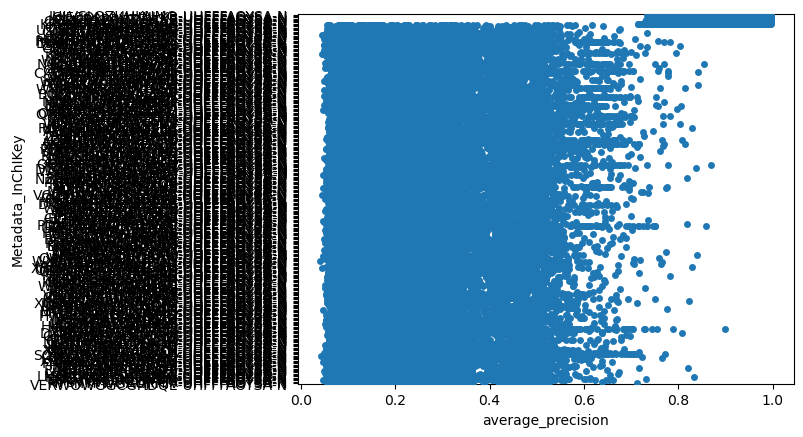

In [116]:
result = pd.read_parquet("Target2_average_precision_batch")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
# result = result[result["trt_dmso"] != "DMSO"]

In [132]:
mAP_batch = mean_average_precision(result, ["ID"], null_size=50000, threshold=0.05, seed=42)
mAP_batch["-log10(p-value)"] = -mAP_batch["corrected_p_value"].apply(np.log10)
# mAP[mAP["below_corrected_p"] == True]

INFO:2024-09-24 21:54:45,014:copairs:Computing null_dist...


  0%|          | 0/2066 [00:00<?, ?it/s]

INFO:2024-09-24 21:54:45,435:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

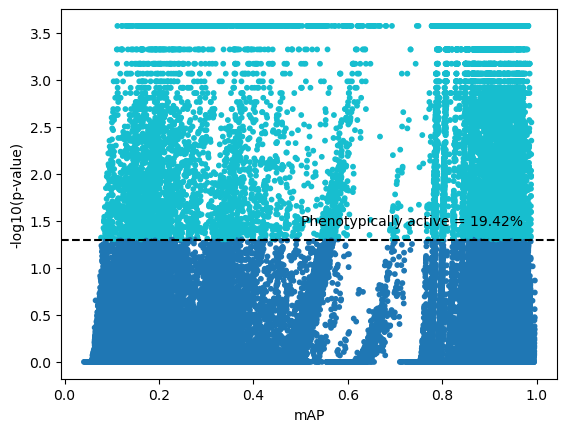

In [133]:
active_ratio = mAP_batch.below_corrected_p.mean()

plt.scatter(data=mAP_batch, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

In [ ]:
# pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
# pos_diffby = ["trt_index"]#["ID"]
# neg_sameby = ["Metadata_Source"]
# neg_diffby = ["trt_dmso"]
# batch_size = 20000


# result = average_precision(
#     metadata_df,
#     features_df,#.to_numpy(),
#     pos_sameby,
#     pos_diffby,
#     neg_sameby,
#     neg_diffby,
#     batch_size,
# )
# result.to_parquet("Target2_average_precision_source")

<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

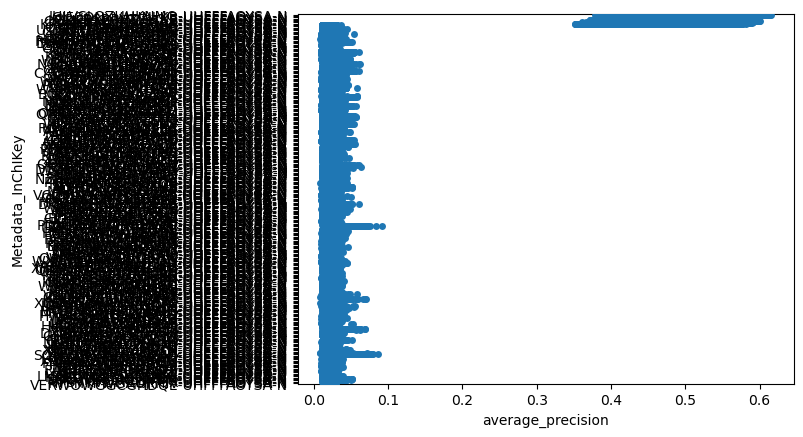

In [9]:
result = pd.read_parquet("Target2_average_precision_source")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [10]:
mAP_source = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP_source["-log10(p-value)"] = -mAP_source["corrected_p_value"].apply(np.log10)

INFO:2024-09-24 22:23:23,681:copairs:Computing null_dist...


  0%|          | 0/391 [00:00<?, ?it/s]

INFO:2024-09-24 22:24:52,904:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

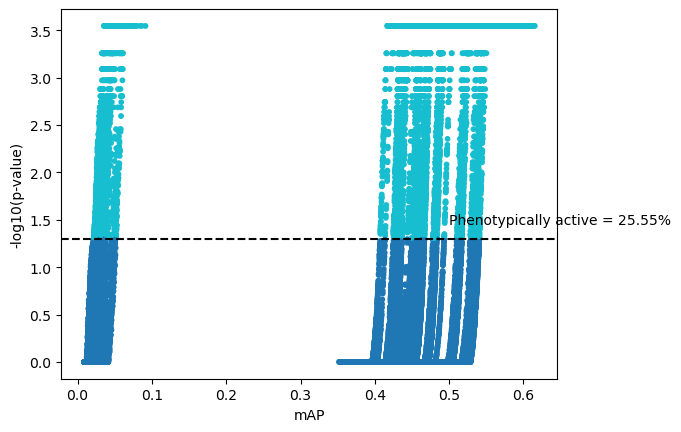

In [11]:
active_ratio = mAP_source.below_corrected_p.mean()

plt.scatter(data=mAP_source, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

## b) with subsetting dmso

We need to regenerate features (as we drop highly correlated features based on the information available from the whole set) We don't want to miss anything so we need to regenerate the original features. 

In [2]:
# metadata_df = pd.read_parquet("Target2_large_set_metadata")
# metadata_df["trt_index"] = metadata_df.index
# metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1

In [3]:
# def constrain_comp_per_source(metadata, min_rep=2, max_rep=(4, 4), group_key="Metadata_Source"):
#     return (metadata.with_columns(
#         pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", group_key).alias("comp_source"),
#         pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", group_key, "Metadata_Well").alias("comp_source_well"),
#         pl.col("Metadata_Well").n_unique().over("Metadata_InChIKey", group_key).alias("unique_well_source"))
#      .with_columns(pl.max_horizontal(pl.lit(1), 
#                                      pl.min_horizontal(pl.col("comp_source_well"), max_rep[0] // pl.col("unique_well_source")))
#                    .alias("sample"))
#      .filter(pl.col("comp_source") >= min_rep)
#      .group_by("Metadata_InChIKey", group_key, "Metadata_Well")
#      .map_groups(lambda df: (df.sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
#                                        .sample(df.select(pl.col("sample").unique()).to_numpy().flatten()[0],
#                                       seed=42)))
#      .with_columns(pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", group_key).alias("comp_source"))
#      .group_by("Metadata_InChIKey", group_key)
#      .map_groups(lambda df: (df.sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
#                                        .sample(min(df.select(pl.col("comp_source").unique()).to_numpy().flatten()[0],
#                                                max_rep[1]),
#                                                seed=42)))
#      .sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
#      .select(pl.all().exclude(["comp_source", "comp_source_well", "unique_well_source", "sample"])))

In [5]:
# metadata_dmso = pl.DataFrame(metadata_df).filter(pl.col("trt_dmso") == "DMSO")

In [7]:
# metadata_dmso_sub = constrain_comp_per_source(metadata_dmso, min_rep=1, max_rep=(3700, 1500), 
#                                               group_key="Metadata_Source")
# subset_dmso_mask = (metadata_df["trt_dmso"] == "trt") | metadata_df["ID"].isin(metadata_dmso_sub["ID"])
# metadata_df_sub = metadata_df[subset_dmso_mask]

In [9]:
# # collect features
# features_sub = gf.load_features('COMPOUND', pl.DataFrame(metadata_df_sub).lazy()).collect()

# #remove metadata
# features_sub = features_sub[:, 4:]

# # transfer to pandas
# features_df_sub = features_sub.to_pandas()
# features_df_sub = features_df_sub[features_df_sub.columns[(features_df_sub.isna().sum(axis=0) == 0) & 
#                                             ((features_df_sub == np.inf).sum(axis=0) == 0)]]
# features_df_sub = features_df_sub[features_df_sub.columns[(features_df_sub.std() != 0)]]
# metadata_df_sub = metadata_df_sub.reset_index(drop=True)
# metadata_df_sub["ID"] = metadata_df_sub.index

# features_df_sub = features_drop_corr_gpu(threshold=0.95).fit_transform(features_df_sub)
# features_df_sub.to_parquet("Target2_sub_set_features")
# metadata_df_sub.to_parquet("Target2_sub_set_metadata")

In [2]:
features_df = pd.read_parquet("Target2_sub_set_features")
metadata_df = pd.read_parquet("Target2_sub_set_metadata")
#trick to avoid computing dmso positive pair
metadata_df["trt_index"] = metadata_df.index
metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1

In [5]:
dmso_scaler = RobustScaler().fit(features_df[metadata_df["trt_dmso"] == "DMSO"])
features_df = dmso_scaler.transform(features_df)

### i) Batch_sub

In [6]:
pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
pos_diffby = ["trt_index"]#["ID"]
neg_sameby = ["Metadata_Batch"]
neg_diffby = ["trt_dmso"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)
result.to_parquet("Target2_average_precision_batch_sub")

INFO:2024-09-25 12:01:39,244:copairs:Indexing metadata...
INFO:2024-09-25 12:01:39,598:copairs:Finding positive pairs...
INFO:2024-09-25 12:02:30,892:copairs:Finding negative pairs...
INFO:2024-09-25 12:02:36,519:copairs:Computing positive similarities...


  0%|          | 0/6625 [00:00<?, ?it/s]

INFO:2024-09-25 12:03:57,901:copairs:Computing negative similarities...


  0%|          | 0/654 [00:00<?, ?it/s]

INFO:2024-09-25 12:04:08,835:copairs:Building rank lists...
INFO:2024-09-25 12:05:45,237:copairs:Computing average precision...
/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos
INFO:2024-09-25 12:05:47,754:copairs:Creating result DataFrame...
INFO:2024-09-25 12:05:47,758:copairs:Finished.


<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

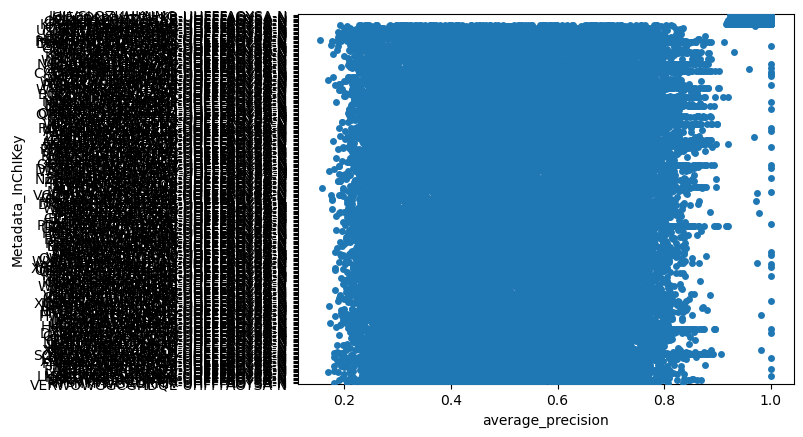

In [7]:
result = pd.read_parquet("Target2_average_precision_batch_sub")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [8]:
mAP_batch_sub = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP_batch_sub["-log10(p-value)"] = -mAP_batch_sub["corrected_p_value"].apply(np.log10)

INFO:2024-09-25 12:06:01,867:copairs:Computing null_dist...


  0%|          | 0/3183 [00:00<?, ?it/s]

INFO:2024-09-25 12:07:16,968:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

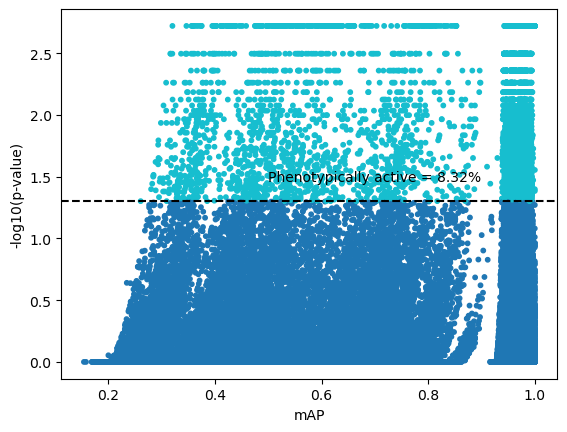

In [9]:
active_ratio = mAP_batch_sub.below_corrected_p.mean()

plt.scatter(data=mAP_batch_sub, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

Base on what we obtained, the batch is not necessarily a good differentiation factor anymore because there is now too few dmso replicate per batch. 
### ii) Source_sub

In [10]:
pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
pos_diffby = ["trt_index"]#["ID"]
neg_sameby = ["Metadata_Source"]
neg_diffby = ["trt_dmso"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)
result.to_parquet("Target2_average_precision_source_sub")

INFO:2024-09-25 12:07:58,114:copairs:Indexing metadata...
INFO:2024-09-25 12:07:58,451:copairs:Finding positive pairs...
INFO:2024-09-25 12:08:48,752:copairs:Finding negative pairs...
INFO:2024-09-25 12:09:38,097:copairs:Computing positive similarities...


  0%|          | 0/6625 [00:00<?, ?it/s]

INFO:2024-09-25 12:11:02,022:copairs:Computing negative similarities...


  0%|          | 0/5849 [00:00<?, ?it/s]

INFO:2024-09-25 12:12:59,105:copairs:Building rank lists...
INFO:2024-09-25 12:15:51,017:copairs:Computing average precision...
/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos
INFO:2024-09-25 12:15:55,333:copairs:Creating result DataFrame...
INFO:2024-09-25 12:15:55,337:copairs:Finished.


<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

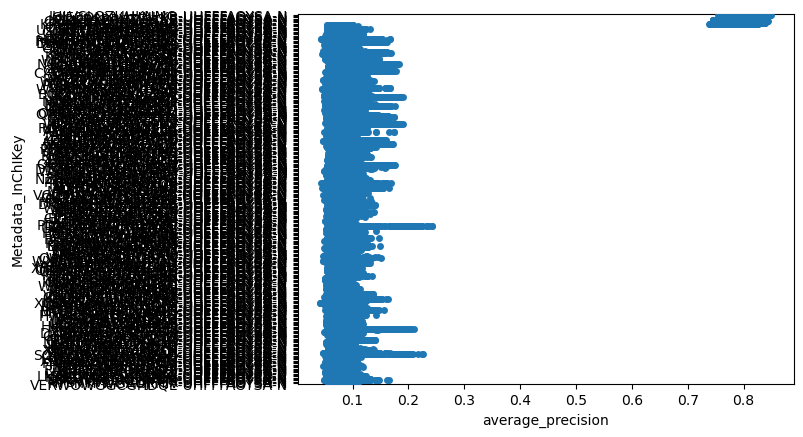

In [11]:
result = pd.read_parquet("Target2_average_precision_source_sub")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [12]:
mAP_source_sub = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP_source_sub["-log10(p-value)"] = -mAP_source_sub["corrected_p_value"].apply(np.log10)

INFO:2024-09-25 12:16:16,461:copairs:Computing null_dist...


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:2024-09-25 12:16:21,773:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

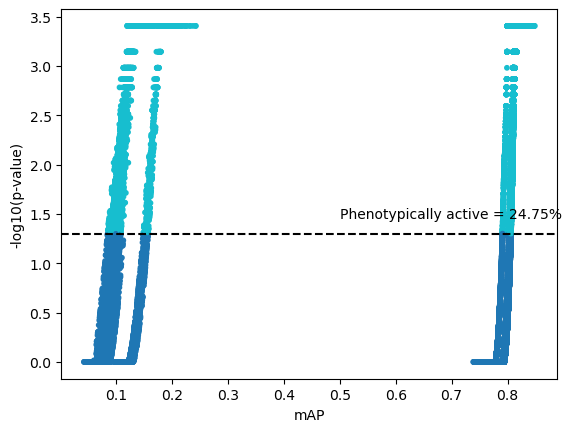

In [13]:
active_ratio = mAP_source_sub.below_corrected_p.mean()

plt.scatter(data=mAP_source_sub, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

Even after balancing, the result remain consistent. This make us more confident with the fact that our balancing per source has been representative. So we can have some confidence about Total Sub, which should be a great approximation of Total (with every dmso). 
### iii) Total_sub

In [14]:
pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
pos_diffby = ["trt_index"]#["ID"]
neg_sameby = []#["Metadata_Source"]
neg_diffby = ["trt_dmso"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)
result.to_parquet("Target2_average_precision_total_sub")

INFO:2024-09-25 12:19:52,953:copairs:Indexing metadata...
INFO:2024-09-25 12:19:53,148:copairs:Finding positive pairs...
INFO:2024-09-25 12:20:45,863:copairs:Finding negative pairs...
INFO:2024-09-25 12:45:31,990:copairs:Computing positive similarities...


  0%|          | 0/6625 [00:00<?, ?it/s]

INFO:2024-09-25 12:46:38,472:copairs:Computing negative similarities...


  0%|          | 0/46785 [00:00<?, ?it/s]

INFO:2024-09-25 12:59:49,277:copairs:Building rank lists...
INFO:2024-09-25 13:12:59,291:copairs:Computing average precision...
/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos
INFO:2024-09-25 13:13:17,535:copairs:Creating result DataFrame...
INFO:2024-09-25 13:13:17,539:copairs:Finished.


<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

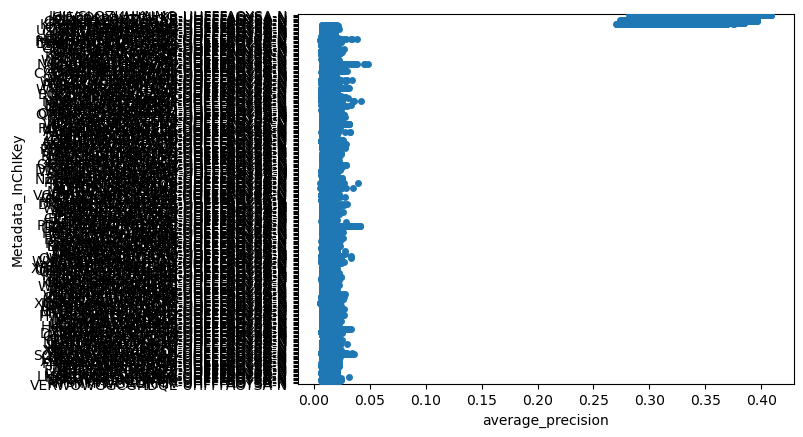

In [15]:
result = pd.read_parquet("Target2_average_precision_total_sub")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [16]:
mAP_total_sub = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP_total_sub["-log10(p-value)"] = -mAP_total_sub["corrected_p_value"].apply(np.log10)

INFO:2024-09-25 13:28:46,547:copairs:Computing null_dist...


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:2024-09-25 13:29:10,609:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

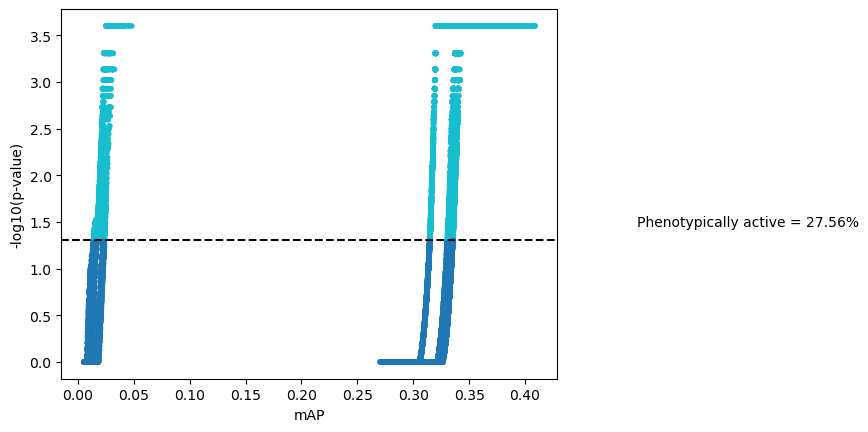

In [17]:
active_ratio = mAP_total_sub.below_corrected_p.mean()
plt.scatter(data=mAP_total_sub, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

## c) Conclusion
Our overall goal with our big dataset is to find a way to downsample it. But instead of just basing our downsampling on metadata information, we want to make sure to only keep the one which are phenotypically active. 
The goal of the filtering per mAP is to do a first downsampling. Then we can see the consistency among moa to further discimminate replicate. And finally we will balance things out based on the metadata. 

In [2]:
metadata_df = pd.read_parquet("Target2_sub_set_metadata")
#trick to avoid computing dmso positive pair
metadata_df["trt_index"] = metadata_df.index
metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1
result = pd.read_parquet("Target2_average_precision_total_sub")
result = result[result["trt_dmso"] != "DMSO"]
mAP_total_sub = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)

INFO:2024-09-25 14:40:50,165:copairs:Computing null_dist...


  0%|          | 0/49 [00:00<?, ?it/s]

INFO:2024-09-25 14:40:50,225:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

In [3]:
mask_mAP = ((metadata_df["trt_dmso"] == "DMSO") | 
 (metadata_df["ID"].isin(mAP_total_sub[mAP_total_sub["below_corrected_p"] == True]["ID"])))
metadata_active = pl.DataFrame(metadata_df[mask_mAP])

# 5) New idea: balance things slightly at the begining and then apply mAP
## a) Subsetting to focus only on compound with 4 moa.  
### i) Retrieve compound with 4 compound per moa

In [67]:
# metadata_df = pd.read_parquet("Target2_large_set_metadata")
# metadata_trt = pl.DataFrame(metadata_df[metadata_df["trt_dmso"] != "DMSO"])
# metadata_trt = (metadata_trt
# .filter((pl.col("moa").str.contains("\|") != True) &
#         (pl.col("Metadata_Source").n_unique().over("Metadata_InChIKey") == pl.col("Metadata_Source").n_unique()))
# .with_columns(pl.col("Metadata_InChIKey").n_unique().over("moa").alias("compound_per_moa"))
# .filter(pl.col("compound_per_moa").is_between(4, 4))
# .select(pl.all().exclude("compound_per_moa")))

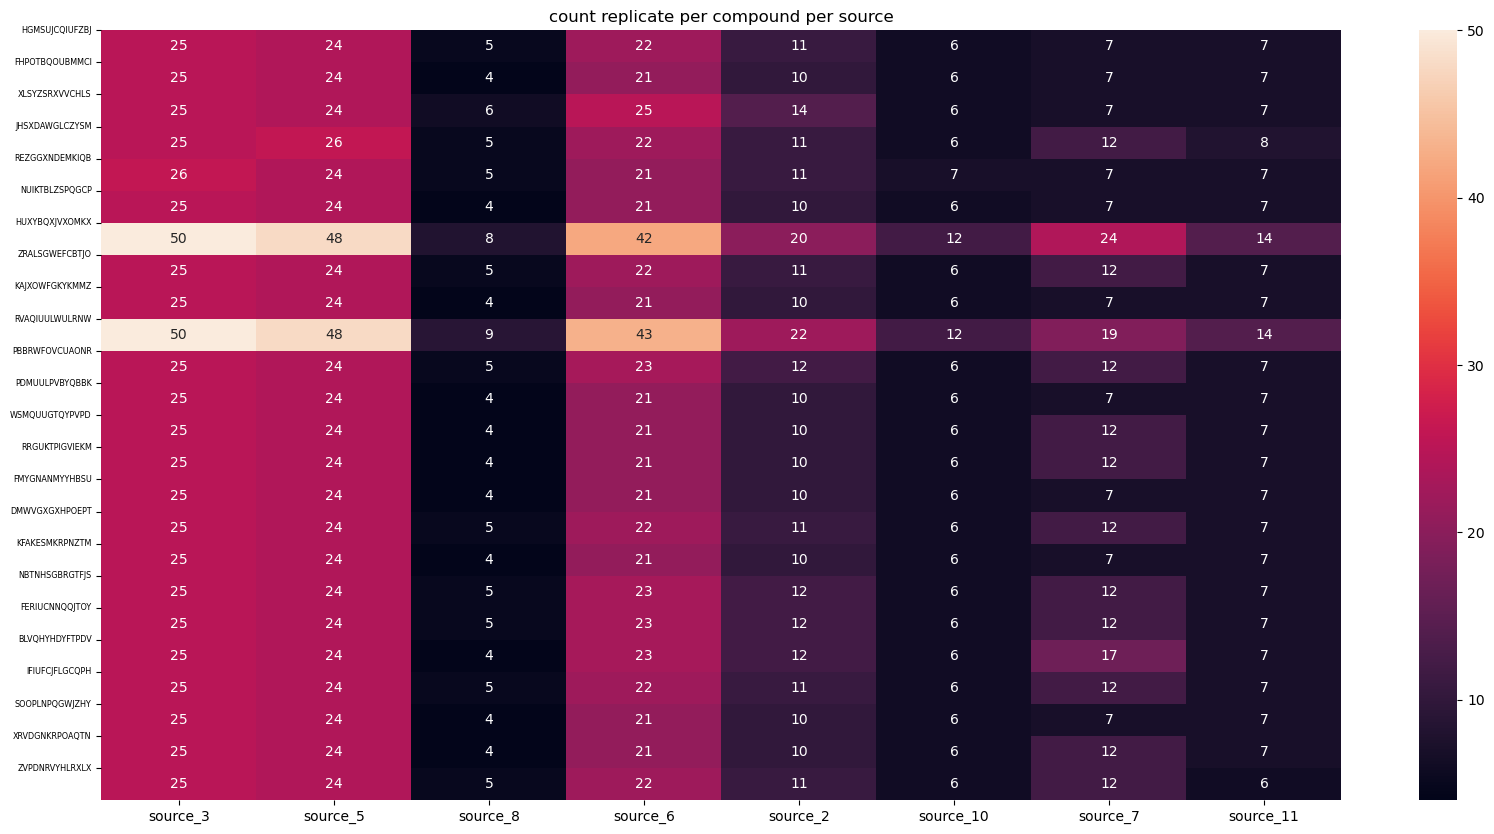

In [68]:
# pdt.replicate_per_source_per_comp(metadata_trt)

### ii) We should adapt our mAP strategy based on this distribution. In fact, the dmso distribution should match the trt distribution. This means that source: 10, 11 and 8 should have the same number of dmso. if we want the same degree of confidence.

In [69]:
# metadata_dmso = pl.DataFrame(metadata_df[metadata_df["trt_dmso"] == "DMSO"])
# metadata_dmso = metadata_dmso.join(metadata_trt.select("Metadata_Plate", "Metadata_Batch").unique(),
#                             on=["Metadata_Plate", "Metadata_Batch"],
#                             how="inner")

In [70]:
# (metadata_dmso.group_by("Metadata_Source").count().rename({"count" : "count_dmso"})
#  .sort(by="Metadata_Source")
#  .join(metadata_trt.group_by("Metadata_Source").count().rename({"count" : "count_trt"})
#      .sort(by="Metadata_Source"),
#       on="Metadata_Source")
#  .with_columns((pl.lit(300) * pl.col("count_trt") / pl.lit(157)).alias("max_rep")))

Metadata_Source,count_dmso,count_trt,max_rep
str,u32,u32,f64
"""source_10""",416,157,300.0
"""source_11""",480,182,347.770701
"""source_2""",1223,281,536.942675
"""source_3""",1632,651,1243.949045
"""source_5""",1600,626,1196.178344
"""source_6""",1846,565,1079.617834
"""source_7""",1773,262,500.636943
"""source_8""",608,117,223.566879


In [71]:
# group_key="Metadata_Plate"
# metadata_dmso_sub = (metadata_dmso.with_columns(
#     pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", group_key).alias("comp_source"),
#     pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", group_key, "Metadata_Well")
#     .alias("comp_source_well"),
#     pl.col("Metadata_Well").n_unique().over("Metadata_InChIKey", group_key).alias("unique_well_source"))
 
#  .join((metadata_dmso.group_by("Metadata_Source").count().rename({"count" : "count_dmso"})
#         .sort(by="Metadata_Source")
#         .join(metadata_trt.group_by("Metadata_Source").count().rename({"count" : "count_trt"})
#               .sort(by="Metadata_Source"),
#               on="Metadata_Source")
#         .with_columns((pl.lit(300) * pl.col("count_trt") / pl.lit(157)).alias("max_rep"))
#         .select(pl.col(["Metadata_Source", "max_rep"]))),
#        on="Metadata_Source")
 
#  .with_columns(pl.max_horizontal(
#     pl.lit(1), 
#     pl.min_horizontal(pl.col("comp_source_well"), 1 * pl.col("max_rep") // pl.col("unique_well_source")))
#                    .alias("sample"))
 
# .group_by("Metadata_InChIKey", group_key, "Metadata_Well")
#  .map_groups(lambda df: (df.sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
#                          .sample(df.select(pl.col("sample").unique()).to_numpy().flatten()[0],
#                                  seed=42)))
 
# .with_columns(pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", "Metadata_Source").alias("comp_source"))
#  .group_by("Metadata_InChIKey", "Metadata_Source")
#  .map_groups(lambda df: (df.sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
#                          .sample(min(df.select(pl.col("comp_source").unique()).to_numpy().flatten()[0],
#                                      df.select(pl.col("max_rep").unique()).to_numpy().flatten()[0]),
#                                                seed=42)))
                     
# .sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
# .select(pl.all().exclude(["comp_source", "comp_source_well", "unique_well_source", "sample", "max_rep"])))

In [76]:
metadata_df_sub = metadata_trt.vstack(metadata_dmso_sub).to_pandas()

In [77]:
# # collect features
# features_sub = gf.load_features('COMPOUND', pl.DataFrame(metadata_df_sub).lazy()).collect()

# #remove metadata
# features_sub = features_sub[:, 4:]

# # transfer to pandas
# features_df_sub = features_sub.to_pandas()
# features_df_sub = features_df_sub[features_df_sub.columns[(features_df_sub.isna().sum(axis=0) == 0) & 
#                                             ((features_df_sub == np.inf).sum(axis=0) == 0)]]
# features_df_sub = features_df_sub[features_df_sub.columns[(features_df_sub.std() != 0)]]
# metadata_df_sub = metadata_df_sub.reset_index(drop=True)
# metadata_df_sub["ID"] = metadata_df_sub.index

# features_df_sub.to_parquet("Target2_small_sub_set_features")
# metadata_df_sub.to_parquet("Target2_small_sub_set_metadata")

## b) Compute phenotypique activity

In [78]:
features_df = pd.read_parquet("Target2_small_sub_set_features")
metadata_df = pd.read_parquet("Target2_small_sub_set_metadata")

features_df = features_drop_corr_gpu(threshold=0.95).fit_transform(features_df)
#trick to avoid computing dmso positive pair
metadata_df["trt_index"] = metadata_df.index
metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1

In [80]:
dmso_scaler = RobustScaler().fit(features_df[metadata_df["trt_dmso"] == "DMSO"])
features_df = dmso_scaler.transform(features_df)

In [81]:
pos_sameby = ["Metadata_InChIKey", "Metadata_Source"]  # We want to match perturbations
pos_diffby = ["trt_index"]#["ID"]
neg_sameby = ["Metadata_Source"]
neg_diffby = ["trt_dmso"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)
# result.to_parquet("Target2_average_precision_source_sub")

INFO:2024-09-25 19:12:40,275:copairs:Indexing metadata...
INFO:2024-09-25 19:12:40,286:copairs:Finding positive pairs...
INFO:2024-09-25 19:12:50,481:copairs:Finding negative pairs...
INFO:2024-09-25 19:12:51,405:copairs:Computing positive similarities...


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:2024-09-25 19:12:51,505:copairs:Computing negative similarities...


  0%|          | 0/130 [00:00<?, ?it/s]

INFO:2024-09-25 19:12:52,604:copairs:Building rank lists...
INFO:2024-09-25 19:12:53,430:copairs:Computing average precision...
/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos
INFO:2024-09-25 19:12:53,475:copairs:Creating result DataFrame...
INFO:2024-09-25 19:12:53,477:copairs:Finished.


<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

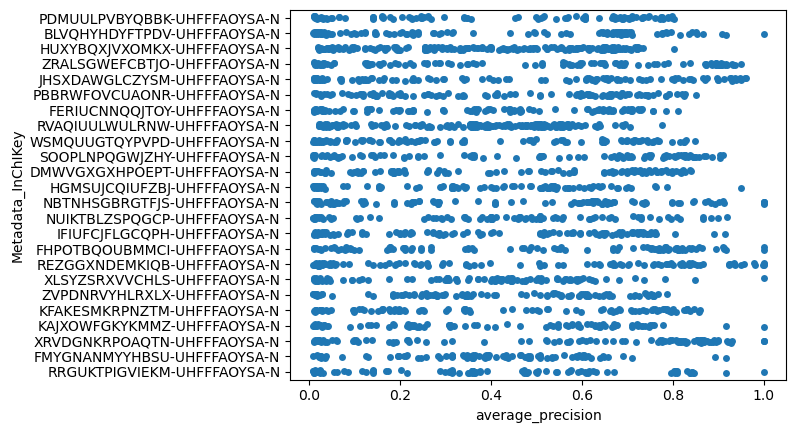

In [82]:
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [83]:
mAP = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP["-log10(p-value)"] = -mAP["corrected_p_value"].apply(np.log10)

INFO:2024-09-25 19:12:58,569:copairs:Computing null_dist...


  0%|          | 0/35 [00:00<?, ?it/s]

INFO:2024-09-25 19:12:59,160:copairs:Computing p-values...


  0%|          | 0/2841 [00:00<?, ?it/s]

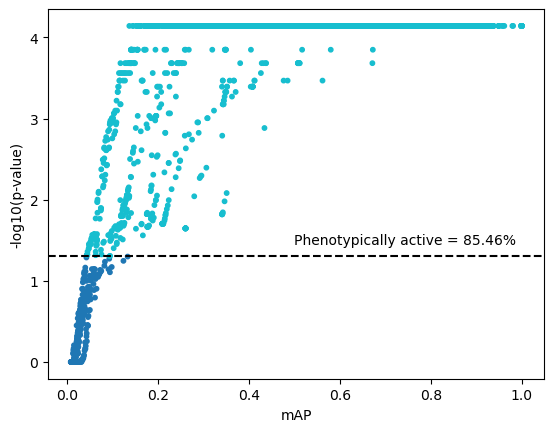

In [84]:
active_ratio = mAP.below_corrected_p.mean()
plt.scatter(data=mAP, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

In [85]:
mask_mAP = ((metadata_df["trt_dmso"] == "DMSO") | 
 (metadata_df["ID"].isin(mAP[mAP["below_corrected_p"] == True]["ID"])))
metadata_active = pl.DataFrame(metadata_df[mask_mAP])

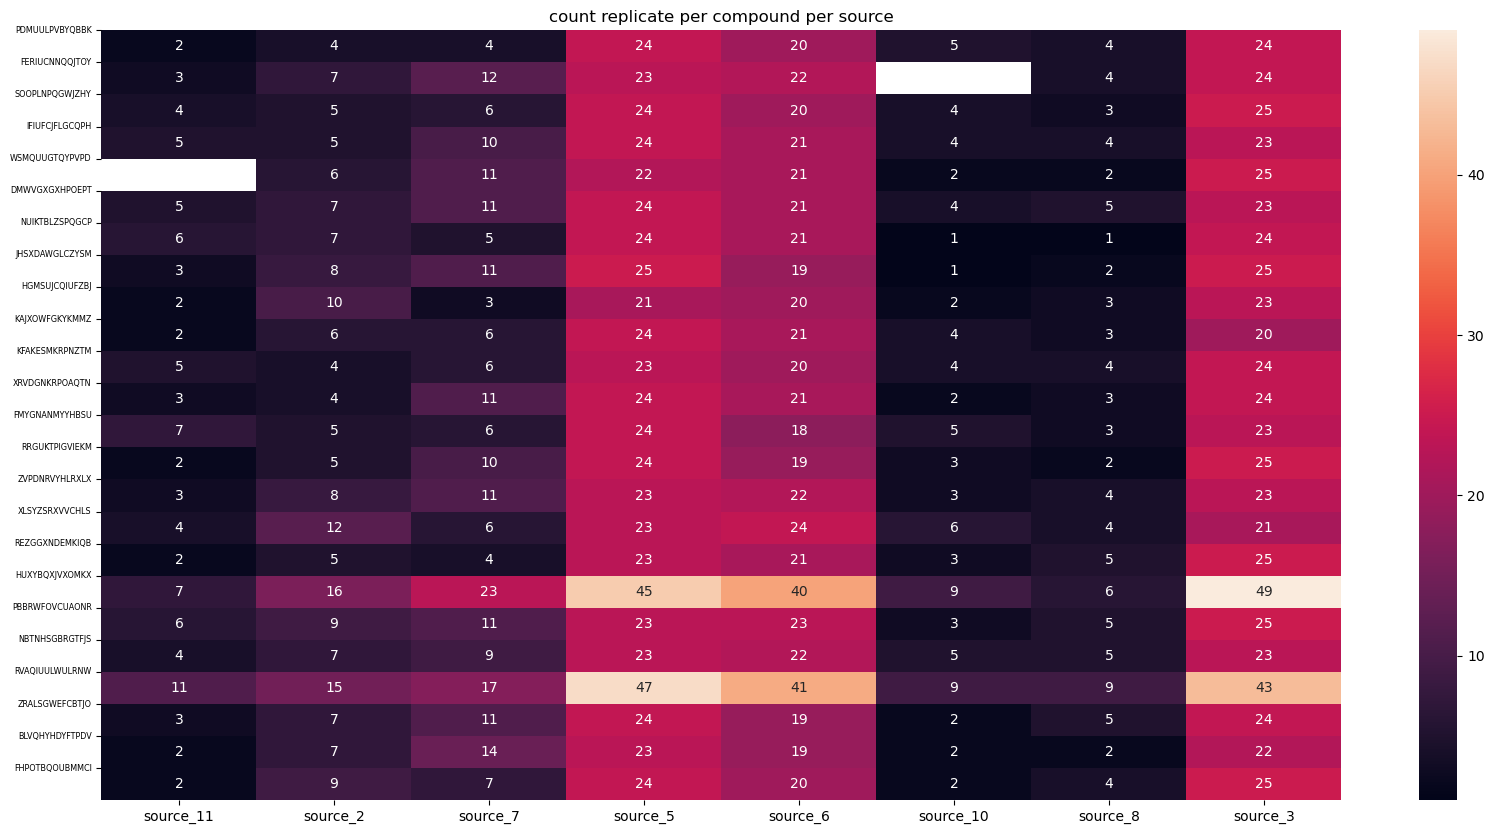

In [86]:
pdt.replicate_per_source_per_comp(metadata_active.filter(pl.col("trt_dmso") != "DMSO"))

Here we decide to remove the whole source 10 and the whole source 11. We also filter out the plate that doesn't exist anymore.

In [89]:
metadata_active = metadata_active.filter(~pl.col("Metadata_Source").is_in(["source_10", "source_11"]))

In [98]:
metadata_active = metadata_active.filter(
    pl.col("Metadata_Plate").is_in(
        metadata_active.filter(pl.col("trt_dmso") != "DMSO").select("Metadata_Plate").to_series().to_list()))

## c) Phenotypic sonsistency within moa (so don't consider dmso)

In [105]:
metadata_active_trt = metadata_active.filter(pl.col("trt_dmso") != "DMSO")

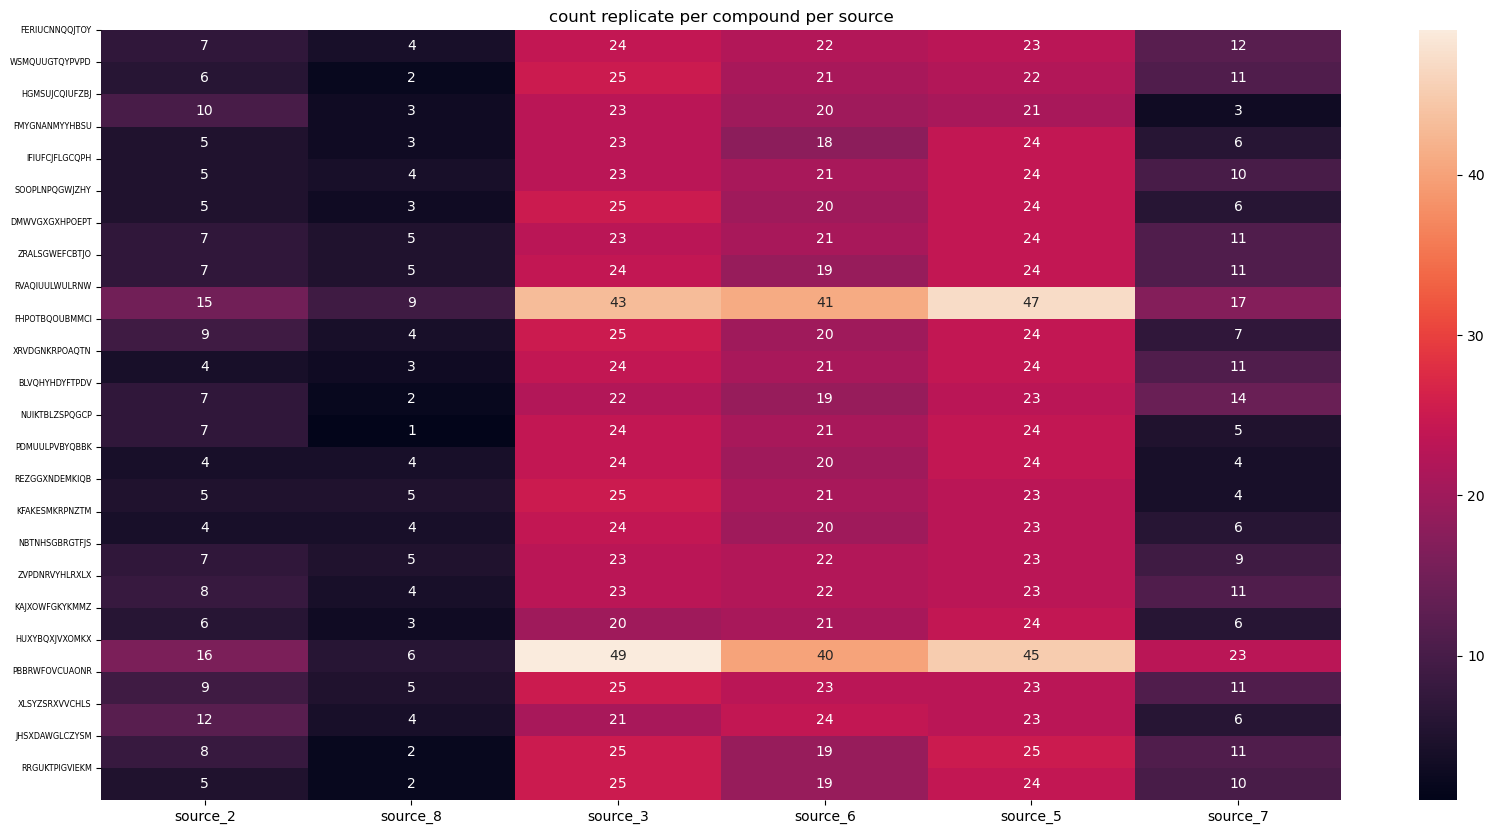

In [108]:
pdt.replicate_per_source_per_comp(metadata_active_trt)

#### Observation: Results could be very biased toward the large sample in term of source, but let's see. 

In [224]:
metadata_active_trt_sub = metadata_active_trt.filter(pl.col("Metadata_Source")
                                                     .is_in(["source_3", "source_6", "source_5"]))

In [226]:
features_df = pd.read_parquet("Target2_small_sub_set_features")
metadata_df = pd.read_parquet("Target2_small_sub_set_metadata")

features_df = features_df.loc[metadata_active_trt_sub["ID"]]
metadata_df = metadata_df.loc[metadata_active_trt_sub["ID"]]
features_df = features_drop_corr_gpu(threshold=0.95).fit_transform(features_df)
#trick to avoid computing dmso positive pair
metadata_df = metadata_df.reset_index(drop=True)
metadata_df["ID"] = metadata_df.index
metadata_df["trt_index"] = metadata_df.index
metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1

In [227]:
pos_sameby = ["moa"]#, "Metadata_Source"]  # We want to match perturbations
pos_diffby = []#["ID"]#["Metadata_InChIKey"]
neg_sameby = []#["Metadata_Source"]#["Metadata_Source"]
neg_diffby = ["moa"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)
# result.to_parquet("Target2_average_precision_source_sub")

INFO:2024-09-25 19:58:35,372:copairs:Indexing metadata...
INFO:2024-09-25 19:58:35,374:copairs:Finding positive pairs...
INFO:2024-09-25 19:58:35,448:copairs:Finding negative pairs...
INFO:2024-09-25 19:58:37,177:copairs:Computing positive similarities...


  0%|          | 0/13 [00:00<?, ?it/s]

INFO:2024-09-25 19:58:37,305:copairs:Computing negative similarities...


  0%|          | 0/65 [00:00<?, ?it/s]

INFO:2024-09-25 19:58:37,923:copairs:Building rank lists...
INFO:2024-09-25 19:58:38,351:copairs:Computing average precision...
INFO:2024-09-25 19:58:38,371:copairs:Creating result DataFrame...
INFO:2024-09-25 19:58:38,373:copairs:Finished.


<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

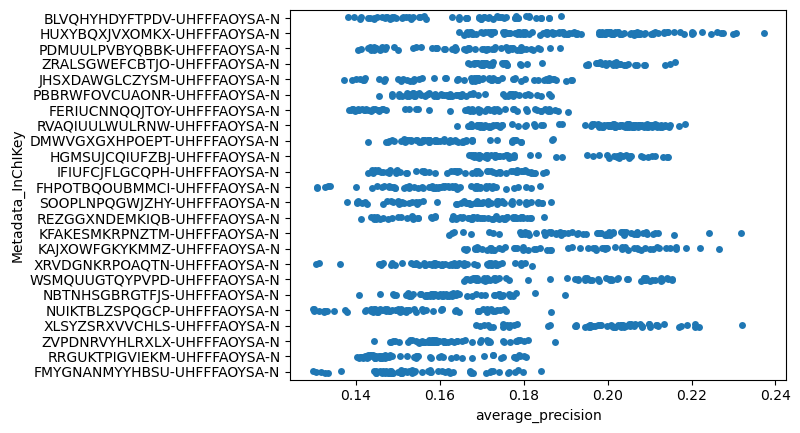

In [228]:
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [236]:
mAP = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP["-log10(p-value)"] = -mAP["corrected_p_value"].apply(np.log10)

INFO:2024-09-25 20:01:41,458:copairs:Computing null_dist...


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:2024-09-25 20:01:41,467:copairs:Computing p-values...


  0%|          | 0/1755 [00:00<?, ?it/s]

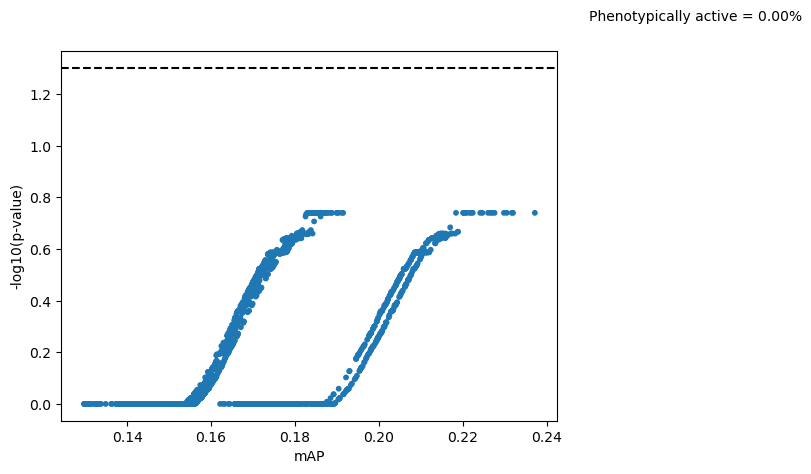

In [237]:
active_ratio = mAP.below_corrected_p.mean()
plt.scatter(data=mAP, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.25, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

In [217]:
mask_mAP = ((metadata_df["trt_dmso"] == "DMSO") | 
 (metadata_df["ID"].isin(mAP[mAP["below_corrected_p"] == True]["ID"])))
metadata_consistent = pl.DataFrame(metadata_df[mask_mAP])

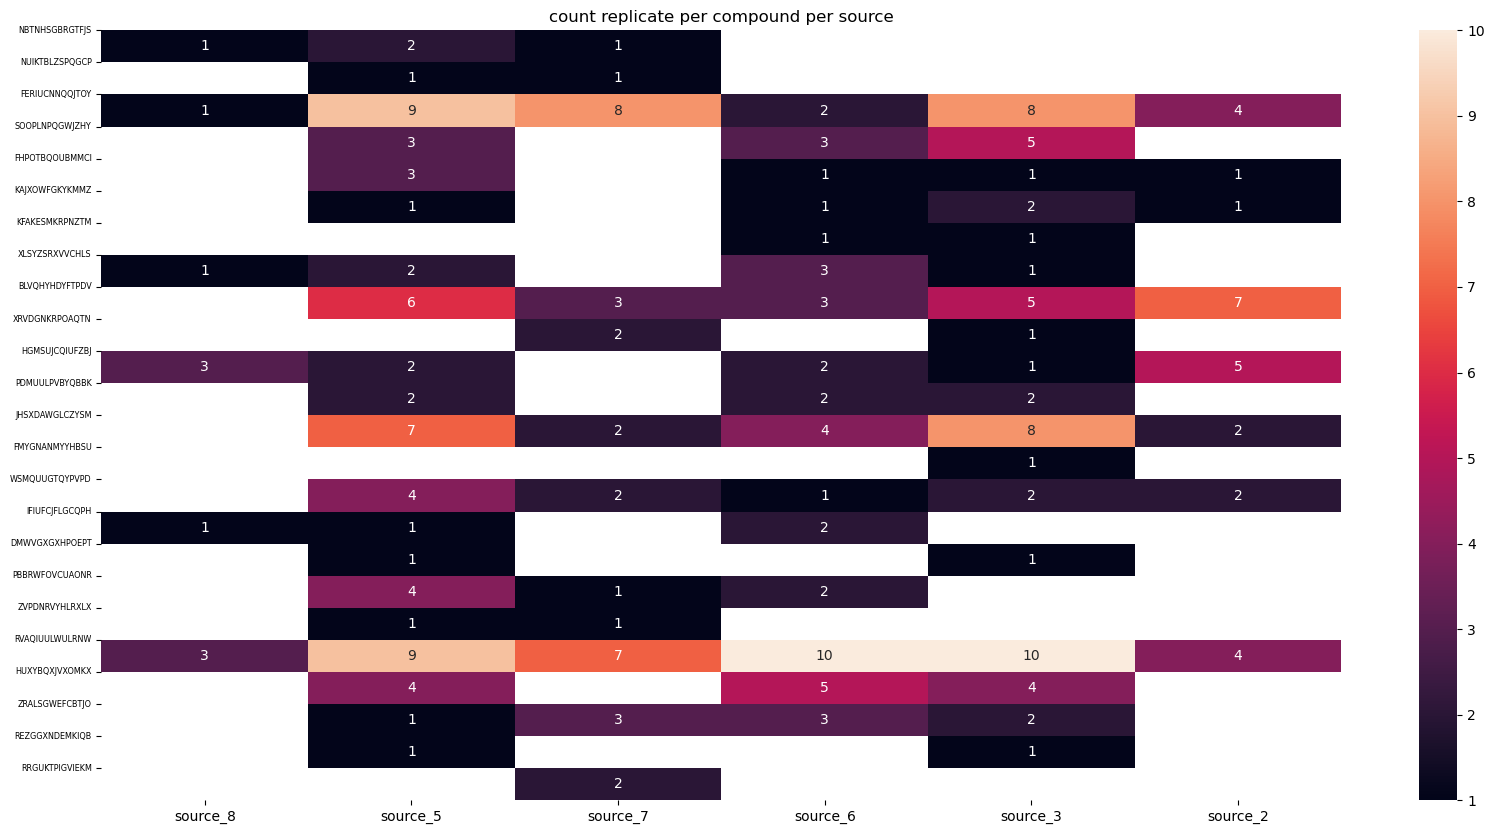

In [218]:
pdt.replicate_per_source_per_comp(metadata_consistent)#.filter(pl.col("trt_dmso") != "DMSO"))

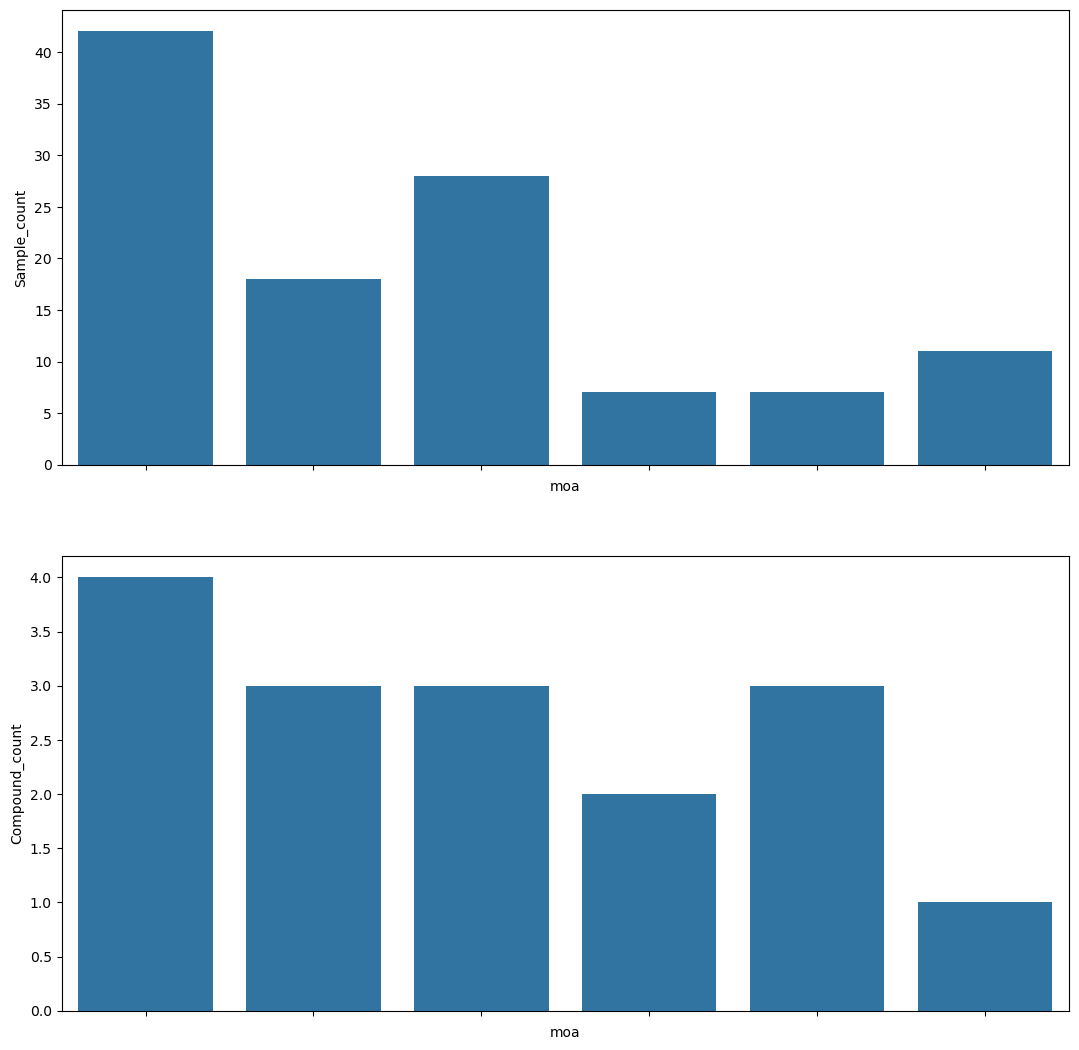

In [147]:
pdt.moa_distribution(metadata_consistent)